In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import time
from tensorflow import keras

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)

# Import of data and creation of split

In [3]:
df = pd.read_csv('housing.csv')

In [4]:
train, test = sklearn.model_selection.train_test_split(df, test_size=0.2)#, random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

def XYsplit(df):
    tdf = df.copy(deep=True)
    return tdf.drop(['house_value'], axis=1, inplace=False), tdf['house_value']

In [5]:
X_train, y_train = XYsplit(train)
print(f"{X_train.shape}")
print(f"{y_train.shape}")
X_test, y_test = XYsplit(test)
print(f"{X_test.shape}")
print(f"{y_test.shape}")

(404, 5)
(404,)
(101, 5)
(101,)


# Functions

In [6]:
def trunc_df(df):
    tdf = df.copy(deep=True)
    return tdf[tdf['house_value'] != 50.0]

In [7]:
def df_transform(df):
    tdf = df.copy(deep=True)
    tdf['crime_rate'] = np.log(tdf['crime_rate'])
    return tdf

In [8]:
class ModelClass():
    def __init__(self, train, full=True, transformed=True, truncate=True, n=5, i=100):
        t1 = time.time()
        tdf = train.copy(deep=True)
        if full is True:
            model = Pipeline([('PCA', sklearn.decomposition.PCA()),
                              ('poly', sklearn.preprocessing.PolynomialFeatures(n)),
                              ('linear', sklearn.linear_model.ElasticNetCV(l1_ratio=[x/i for x in range(1,i)],
                                                                           normalize=True,
                                                                           max_iter=100000,
                                                                           #cv=sklearn.model_selection.LeaveOneOut(),
                                                                           cv=5,
                                                                           n_jobs=-2,
                                                                           )
                              )
                             ])
        else:
            model = sklearn.linear_model.LinearRegression()
        if transformed is True:
            tdf = df_transform(tdf)
        else:
            pass
        if truncate is True:
            train_df = trunc_df(tdf)
        else:
            train_df = tdf
        print(f"Total training set: {train_df.shape}")
        X, y = XYsplit(train_df)
        model.fit(X=X, y=y)
        print(f"Fitted! Internal R^2: {model.score(X=X, y=y)}")
        print(f"Internal: if truncated, then score is only without values including 50.0")
        self.train = train
        self.full = full
        self.transformed = transformed
        self.truncate = truncate
        self.model = model
        print(f"Elapsed time: {time.time()-t1}")
        return None
    
    def test(self, test, graph=False):
        X_test, y_test = XYsplit(test)
        y_pred = self.model.predict(X_test)
        #y_pred = np.where(y_pred < 0, 0, y_pred)
        if self.truncate is True:
            y_pred = np.where(y_pred > 50.0, 50.0, y_pred)
        print(f"MSE: {sklearn.metrics.mean_squared_error(y_pred, y_test)}")
        print(f"MAE: {sklearn.metrics.mean_absolute_error(y_pred, y_test)}")
        if graph is True:
            sns.regplot(x=y_pred, y=y_test, fit_reg=True)
        return (sklearn.metrics.mean_squared_error(y_pred, y_test), sklearn.metrics.mean_absolute_error(y_pred, y_test))

# Test of linear regression models

Total training set: (392, 6)
Fitted! Internal R^2: 0.8482565878229332
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 112.41599941253662
MSE: 104296.01310335191
MAE: 61.32106150458646


(104296.01310335191, 61.32106150458646)

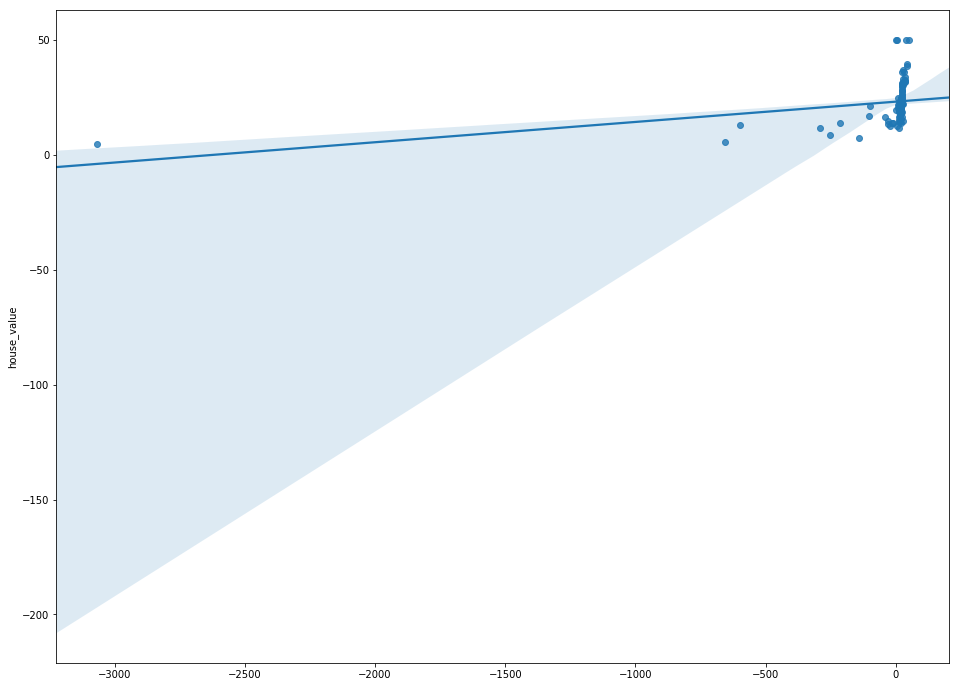

In [9]:
BestLinear = ModelClass(train)
BestLinear.test(test, graph=True)

In [10]:
print(f"ElasticNetCV alpha: {BestLinear.model.named_steps['linear'].alpha_}")
print(f"ElasticNetCV ratio: {BestLinear.model.named_steps['linear'].l1_ratio_}")
print(f"ElasticNetCV alphas: {BestLinear.model.named_steps['linear'].alphas_}")

ElasticNetCV alpha: 0.008176877601688452
ElasticNetCV ratio: 0.99
ElasticNetCV alphas: [[2.30551603e+01 2.15013197e+01 2.00522027e+01 ... 2.65078318e-02
  2.47212927e-02 2.30551603e-02]
 [1.15275801e+01 1.07506598e+01 1.00261013e+01 ... 1.32539159e-02
  1.23606463e-02 1.15275801e-02]
 [7.68505343e+00 7.16710655e+00 6.68406756e+00 ... 8.83594394e-03
  8.24043089e-03 7.68505343e-03]
 ...
 [2.37682065e-01 2.21663089e-01 2.06723739e-01 ... 2.73276617e-04
  2.54858687e-04 2.37682065e-04]
 [2.35256738e-01 2.19401221e-01 2.04614313e-01 ... 2.70488080e-04
  2.52258089e-04 2.35256738e-04]
 [2.32880407e-01 2.17185047e-01 2.02547502e-01 ... 2.67755877e-04
  2.49710027e-04 2.32880407e-04]]


Total training set: (404, 6)
Fitted! Internal R^2: 0.6195400448942139
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 0.0023081302642822266
MSE: 36.940309983134306
MAE: 4.014783659105346


(36.940309983134306, 4.014783659105346)

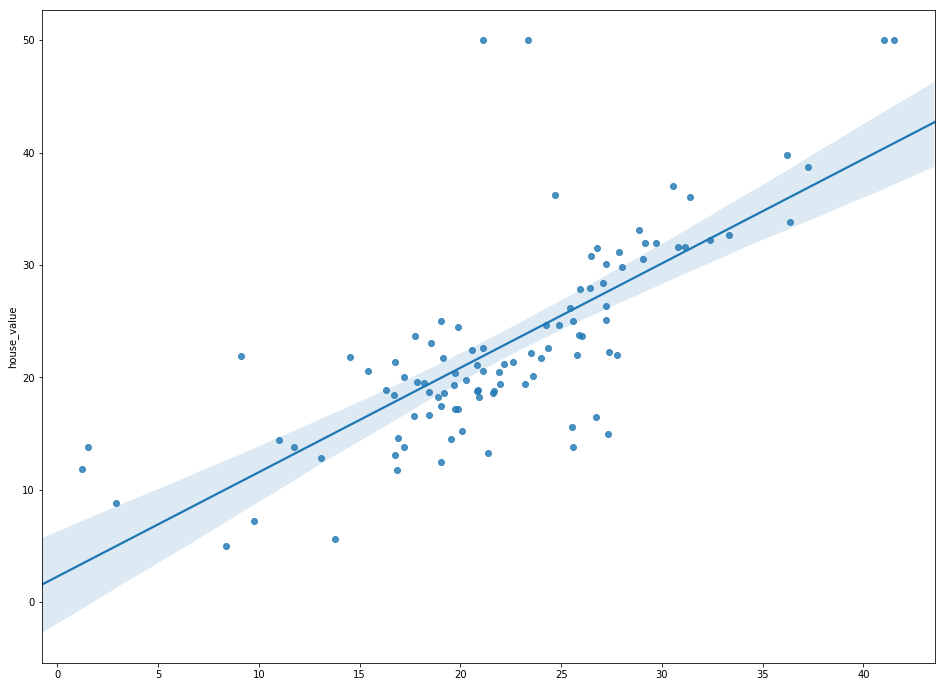

In [11]:
BasicLinear = ModelClass(train, full=False, truncate=False, transformed=False)
BasicLinear.test(test, graph=True)

In [12]:
results = []
start_time = time.time()
for i in range(8):
    temp = format(i, '03b')
    full = bool(int(temp[0]))
    truncate = bool(int(temp[1]))
    transformed = bool(int(temp[2]))
    print(full, truncate, transformed)
    model = ModelClass(train, full=full, truncate=truncate, transformed=transformed)
    MSE, MAE = model.test(test)
    results.append((i, MSE, MAE))
print(results)
print(time.time()-start_time)

False False False
Total training set: (404, 6)
Fitted! Internal R^2: 0.6195400448942139
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 0.002687692642211914
MSE: 36.940309983134306
MAE: 4.014783659105341
False False True
Total training set: (404, 6)
Fitted! Internal R^2: 0.6153779586207084
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 0.002205371856689453
MSE: 57.80641236131241
MAE: 5.0153327224460655
False True False
Total training set: (392, 6)
Fitted! Internal R^2: 0.6857640247994524
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 0.002537250518798828
MSE: 39.43217774134539
MAE: 4.106664270534717
False True True
Total training set: (392, 6)
Fitted! Internal R^2: 0.6843771103747501
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 0.0027043819427490234
MSE: 64.31806883130508
MAE: 5.270990442798174
True False False
Total training s

In [13]:
results = pd.DataFrame(results, columns=('index', 'MSE', 'MAE'))
results

,index,MSE,MAE
0,0,36.940310,4.014784
1,1,57.806412,5.015333
2,2,39.432178,4.106664
3,3,64.318069,5.270990
4,4,37.237270,3.652100
5,5,155786.556770,65.115350
6,6,39.429814,3.362983
7,7,104296.013103,61.321062


Total training set: (392, 6)
Fitted! Internal R^2: 0.8607130668062906
Internal: if truncated, then score is only without values including 50.0
Elapsed time: 118.03676962852478
MSE: 39.4298139131414
MAE: 3.362982878108108


(39.4298139131414, 3.362982878108108)

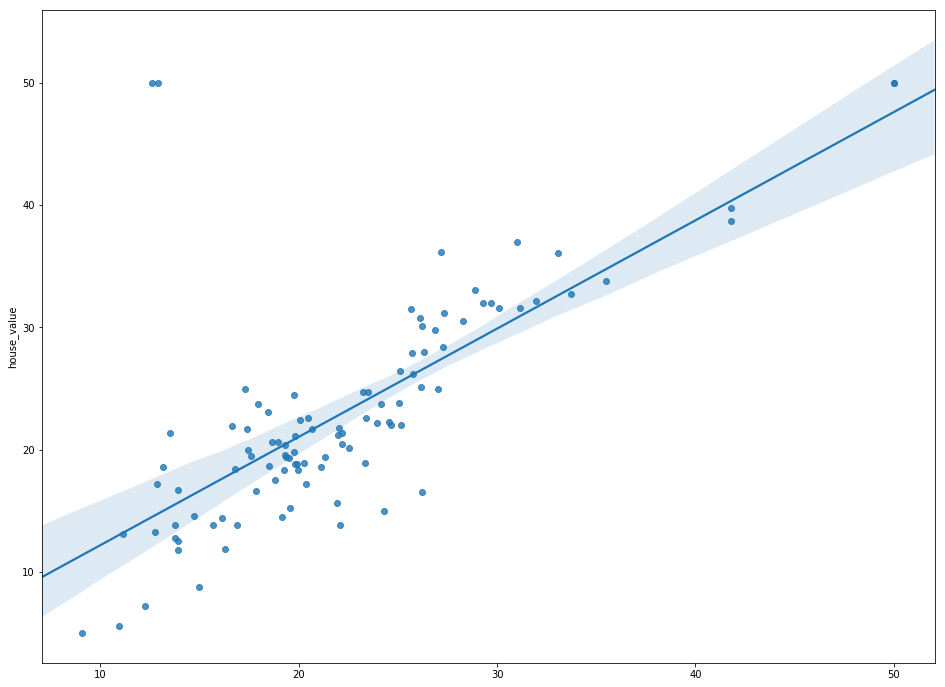

In [14]:
BestModel = ModelClass(train, transformed=False)
BestModel.test(test, graph=True)

# NN models